Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your collaborators below:

In [1]:
COLLABORATORS = "Cyan Bastiaans"

---

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# special imports for running and evaluating the Elman network
from elman import train_Elman, predict_Elman

<div class="alert alert-warning">
**N.B.** The ideas in this notebook draw heavily from the readings
<ol>
<li> Elman, J. L. (1990). Finding structure in time. _Cognitive Science, 14_, 179-211.
<li>McClelland, J., & Rumelhart, M. (1986). Past tenses of English verbs. In McClelland, J. and Rumelhart, D. (Eds.) _Parallel distributed processing: Explorations in the microstructure of cognition. Vol. 2: Applications_ (pp. 216-271). Cambridge, MA: MIT Press.
</ol>
<br>
If you are confused about some of the ideas in this notebook or would like further clarification, we recommend having a look there.
</div>

## Introduction

One of the most successful (and controversial) applications of neural
networks has been as models of human language. You will test whether a
simple neural network is capable of learning the rule underlying a
context-free language.

The language $a^nb^n$, being the set of all strings containing a
sequence of $a$'s followed by a sequence of $b$'s of the same length
is a simple example of a language that can be generated by a
context-free grammar but not a finite-state grammar. Human languages
exhibit similar long-range constraints -- for example, a plural noun
at the start of a sentence affects conjugation of a verb at the end,
regardless of what intervenes. Some criticisms of applications of
neural networks to human languages are based upon their apparent
reliance on local sequential structure, which makes them seem much
more similar to finite-state grammars than to context-free
grammars. An interesting question to explore is thus whether a
recurrent neural network can learn to generalize a simple rule
characterizing a long-range dependency, such as the rule underlying
$a^nb^n$.

Recall that an "Elman" network, as discussed by Elman (1990), is a
recurrent network where the activation of the hidden units at the
previous timestep are used as input to the hidden units on the current
timestep. This type of network architecture allows the
network to learn about sequential dependencies in the input data. In this notebook we will evaluate whether such a network can learn an $a^nb^n$
grammar. Here we formalize learning a grammar as being able to correctly
predict what the next item in a sequence should be given the
rules of the grammar. Therefore, the output node represents the
networks's prediction for what the next item in the sequence (the next
input) will be -- it outputs a $1$ if it thinks the current input will
be followed by an $a$, and outputs a $0$ if it thinks the current
input will be followed by a $b$.

## Data	

We will use the `abdata.npz` dataset for this problem. This dataset has two keys:

In [3]:
ab_data = np.load("data/abdata.npz")
ab_data.keys()

['train_data', 'test_data']

The array `train_data` contains the sequence we will use to train our network: 

In [4]:
train_data = ab_data['train_data']
train_data

array([1, 1, 1, ..., 1, 0, 0])

The array `test_data` contains the sequence we will use to evaluate the
network: 

In [5]:
test_data = ab_data['test_data']
test_data

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In both `train_data` and `test_data` a $1$ represents an $a$ and a $0$ represents a $b$.

`train_data` was constructed by concatenating a randomly ordered
set of strings of the form $a^nb^n$, with $n$ ranging from 1 to 11.
The frequency of sequences for a given value of $n$ in the training set
are given by `np.ceil(50/n)`, thus making them inversely proportional to $n$.
The `np.ceil` function returns the smallest integer greater or equal to
its input. For example, `np.ceil(3)` is 3, but `np.ceil(3.1)` is
4 . `test_data` contains an ordered sequence of strings of the form
$a^nb^n$, with $n$ increasing from 1 to 18 over the length of the
string.

---

## Part A (1 point)

In order to train your network, you will need both training input and
training output. That is, you need a sequence of inputs of the form
$a^nb^n$, and a corresponding sequence with the correct output for
each item in the input sequence.

For this problem we're going to use `train_data[:-1]` as the
input training sequence, and `train_data[1:]` as the output
training sequence.

<div class="alert alert-success">
Explain why these are appropriate input and output
sequences. If you're confused by what the sequences
`train_data[:-1]` and `train_data[1:]` look like,
try creating them in a scratch cell and compare them to `train_data`.</div>

Since we are feeding this network one letter at a time, train_data[:-1] is the appropriate input sequence because since it represents the exact list except the last value, we can use this to compare this list to the output values, which are 1 value ahead. Furthermore, train_data[1:] is the correct output sequence because it represents every element in the list except the very first one, which, again, won't be used in order to compare the input and output lists. Since we are comparing the input sequence to the *next* element in the output sequence, we need to strip the output's first value and the input's last value in order to effectively train them.

---

## Part B (0.5 points)

We have provided you with a function, `train_Elman`, which takes four arguments:
- `input` -- the training input sequence
- `output` -- the training output sequence
- `num_hidden` -- the number of hidden units
- `num_iters` -- the number of training iterations


`train_Elman` will create a network with one input node, the specified number of
hidden units, and one output node, and then train it on the training
data for the specified number of iterations. The network sees the
training data one input at a time (in our case, it sees a single $1$
or $0$ per time step).

Complete the function `anbn_learner` below to train an "Elman"
network with two hidden units using the provided function `train_Elman` (remember
to use the input and output sequences from Part A). Train the network
for 100 iterations, and return the final output of the network.

In [6]:
def anbn_learner(train_data):
    """
    Creates an "Elman" neural network with two hidden units and trains it
    on the provided data.

    Parameters
    ----------
    train_data: numpy array of shape (n,)
        the data on which to train the Elman network

    Returns
    -------
    net: dictionary with 2 keys
        a dictionary containing the weights of the network. Valid keys are 1 and 2. 
        key 1 is for the weights between the input and the hidden units, and 
        key 2 is for the weights between the hidden units and the output units.
    """
    return train_Elman(train_data[:-1], train_data[1:], 2, 100)

In [7]:
"""Check that anbn_learner returns the correct output"""
from numpy.testing import assert_array_equal
from nose.tools import assert_equal, assert_almost_equal 

# check that abdata hasn't been modified
ab = np.load("data/abdata.npz")
assert_array_equal(test_data, ab['test_data'], "test_data array has changed")
assert_array_equal(train_data, ab['train_data'], "train_data array has changed")

# generate test data
traindata = np.zeros(20)
traindata[10:] = 1.

net = anbn_learner(traindata)

# check that net has the correct shape and type
assert_equal(type(net), dict, "net should be a dict of network weights")
assert_equal(len(net), 2, "incorrect number of layers in net")
assert_equal(list(net.keys()), [1,2], "keys for net should be 1 and 2")

# check the dimensions of the weight matrices
assert_equal(net[1].shape, (2,4), "invalid network weights for the input -> hidden layer")
assert_equal(net[2].shape, (1,3), "invalid network weights for the hidden -> output layer")

# check the weight matrix sums to the correct value on testdata
assert_almost_equal(np.sum(net[1]), -1.9326, places=4, msg="weights for input --> hidden layer are incorrect")
assert_almost_equal(np.sum(net[2]), 0.01825, places=4, msg="weights for hidden --> output layer are incorrect")
print("Success!")

Success!


Once the network is trained, you can test it on a new set of sequences
and evaluate its predictions to see how well it has learned the target
 grammar. To generate predictions from the trained network, we use the provided function `predict_Elman`. Try using your trained network to predict the sequences in `test_data`:

In [8]:
net = anbn_learner(train_data) # train the Elman network on train_data
predictions = predict_Elman(net, test_data) # use the trained network to predict test_data
predictions

array([ 0.73397229,  0.35926335,  0.66985116,  0.79101561,  0.19305259,
        0.21020227,  0.73471647,  0.76686645,  0.72591299,  0.31810992,
        0.14249654,  0.31991108,  0.71258056,  0.77525399,  0.72032276,
        0.75362485,  0.27381194,  0.1661838 ,  0.31012131,  0.22791155,
        0.72665987,  0.77072442,  0.72328739,  0.75233251,  0.73745893,
        0.30002543,  0.15225045,  0.31589257,  0.22545912,  0.26761338,
        0.72136715,  0.77239806,  0.72222083,  0.75279913,  0.73719789,
        0.74548225,  0.28737596,  0.1589701 ,  0.31312083,  0.22663675,
        0.26716873,  0.25029313,  0.72354509,  0.7717496 ,  0.72262933,
        0.75262155,  0.73729726,  0.74543301,  0.74125723,  0.29410481,
        0.15539726,  0.31459672,  0.22600978,  0.26740556,  0.25020501,
        0.25696487,  0.72275178,  0.77197919,  0.72248656,  0.7526835 ,
        0.73726263,  0.74545017,  0.74124815,  0.74343669,  0.29065546,
        0.15722885,  0.31384081,  0.2263309 ,  0.2672843 ,  0.25

---

## Part C (1.25 points)

The squared error (SE) for a prediction $p_i$ in the prediction vector ${\bf p}$
compared to a target value ${y_i}$ in the target vector ${\bf y}$ is

\begin{equation}
SE_i = (p_i-y_i)^2
\end{equation}

That is, the squared error is just the squared difference between the
predicted and target value.
	
Complete the function `squared_error`, which takes in an array of test data and an array of
predictions. The function should return an error array containing the SE for each
of the predictions of the network compared against the corresponding value in `test_data`. 

<div class="alert alert-warning">Remember that the predictions refer to the _next_ item in the sequence
(e.g.  `predictions[0]` should be compared to
`test_data[1]`, etc.). You should append an $a$ to the end of your test data to equate the array sizes (describing the start of a new sequence of $a^nb^n$). </div>

In [9]:
def squared_error(predictions, test_data):
    """
    Uses equation 1 to compute the SE for each of the predictions made 
    by the network.

    Parameters
    ----------
    predictions: numpy array of shape (n,)
        an array of predictions from the Elman network
    
    test_data: numpy array of shape (n,) 
        the array of test data from which predictions were generated

    Returns
    -------
    se_vector: numpy array of shape (n,)
        an array containing the SE for each of items in predictions 
    """
    test_data = np.append(test_data, [1])
    squarerror = np.zeros(predictions.size)
    n = 0
    while n < predictions.size:
        squarerror[n] = (predictions[n] - test_data[n+1])**2
        n = n+1    
    return squarerror

In [10]:
"""Check that squared_error returns the correct output"""
from nose.tools import assert_equal

# generate test data
pred = np.array([1, 0, 1])
test = np.array([0, 1, 0])
se = squared_error(pred, test)

# check that squared_error returns the correct output for testdata
assert_equal(se.dtype, np.float64, "squared_error should return an array of floats")
assert_equal(se.shape, (3,), "squared_error returned an array of the incorrect size on the validate testdata")
assert_array_equal(se, np.zeros(3), "squared_error should return all zeros on the validate testdata")

# check that squared_error compares the correct elements
pred = np.zeros(1)
test = np.zeros(1)
se = squared_error(pred, test)
assert_equal(se, np.ones(1), "squared_error([0],[0]) should have returned a 1 (did you remember to append an a to testdata?")

print("Success!")

Success!


---

## Part D (1.25 points)

Use matplotlib to plot a bar graph of the squared error for each training example. Don't forget to provide a title and label your $x$ and $y$ axes!

<div class="alert alert-warning">If you have difficulty interpreting this graph, you may want to
examine a few of the values in `test_data`, `predictions`, and your `mse_vector` to see how they are related.</div>

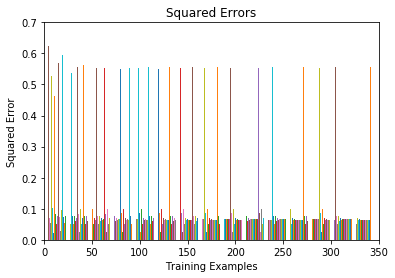

In [11]:
# initialize network and train on train_data
net = anbn_learner(train_data)
predictions = predict_Elman(net, test_data)

# use the trained network to predict test_data
se_vector = squared_error(predictions, test_data)

# create the figure
fig, axis = plt.subplots()
axis.set_xlim([0.0, 350.0]), axis.set_ylim([0.0,.7])

# YOUR CODE HERE
axis.set_title("Squared Errors")
axis.set_xlabel("Training Examples")
axis.set_ylabel("Squared Error")
t = 0
while t < test_data.size:
    axis.bar(t, se_vector[t])
    t += 1

To get a better idea of what is going on, let's have a look at the values in `test_data` where the prediction error spikes:

In [12]:
# prints the 3 values preceding and 2 values following the spot where 
# the prediction error >= 0.5
error_spike_idxs = np.argwhere(se_vector >= 0.5) + 1
error_spike_idxs = error_spike_idxs[:-1]

for i in error_spike_idxs:
    print('3 values preceding MSE spike: {}\tValue at MSE spike: {}'
          '\t\t2 values following MSE spike: {}'\
          .format(test_data[i[0]-3:i[0]], test_data[i[0]], test_data[i[0]+1:i[0]+3]))

3 values preceding MSE spike: []	Value at MSE spike: 0		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [0 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 1]
3 values preceding MSE spike: [1 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 1]	Value at MSE spike: 0		2 values following MSE spike: [0 0]
3 values preceding MSE spike: [0 0 0]	Value at MSE spike: 1		2 values following MSE spike: [1 1]
3 values preceding MSE spike: [1 1 

In [13]:
from numpy.testing import assert_array_equal, assert_allclose 
from nose.tools import assert_equal, assert_not_equal    

# check that a title and labels were included
assert_not_equal(axis.get_title(), '', "no title given")
assert_not_equal(axis.get_xlabel(), '', "no x label set")
assert_not_equal(axis.get_ylabel(), '', "no y label set")

# check that axis limits are correct
assert_equal(axis.get_xlim(), (0.0, 350.0), "incorrect x-axis limits")
[assert_allclose(*x, err_msg="incorrect y-axis limits") for x in zip(axis.get_ylim(), np.array([0.0, 0.7]))]

print("Success!")

Success!


---

## Part E (2 points)

<div class="alert alert-success">Earlier we said that we can evaluate whether the network has learned
the grammar by looking at the predictions it makes. If the network has
learned the $a^nb^n$ grammar, in what cases should it make correct
predictions? When should it make incorrect predictions? (**1 point**)</div>

In the case if the network has learned the $a^nb^n$ grammar, it should make correct predictions when the grammar switches from b to a. It should make incorrect predicitions when it switches from a to b.

<div class="alert alert-success">Do your predictions about when the network should make correct/incorrect predictions if it has learned the $a^nb^n$ grammar match the MSE values you plotted in Part D? (**1 point**)</div>

No, the predictions about when the network should make correct/incorrect predictions if it has learned this grammar do not match the MSE values plotted in the graph. As we can see in the graph of the prediction error spikes, the network makes incorrect predictions when it switches from a to b **and** when it switches from b to a. If the network has learned, then it would not make incorrect predictions from b to a, it would always correctly guess in this case.

---

## Part F (1 point)

<div class="alert alert-success">At what level of the Chomsky hierarchy is the $a^nb^n$ grammar? How does this compare to the level of most natural languages? Use this to explore the implications of your results from Part E for using the Elman network to model the relationships present in human language.</div>

The $a^nb^n$ grammar is a context-free grammar. Most natural languages lie in the context sensitive level, which is one level above context-free. The results from Part E suggest that the Elman network cannot learn a context-free grammar. Therefore, because the network can't learn a context-free grammar, it is very likeley that the Elman network would not be able to learn context-sensitive grammars, and thus would not be able to model human language.

---

Before turning this problem in remember to do the following steps:

1. **Restart the kernel** (Kernel$\rightarrow$Restart)
2. **Run all cells** (Cell$\rightarrow$Run All)
3. **Save** (File$\rightarrow$Save and Checkpoint)

<div class="alert alert-danger">After you have completed these three steps, ensure that the following cell has printed "No errors". If it has <b>not</b> printed "No errors", then your code has a bug in it and has thrown an error! Make sure you fix this error before turning in your problem set.</div>

In [14]:
print("No errors!")

No errors!
